### 手動で選別したコーナーのマスク画像(img/corner2/edited_corner/)と前景画像(img/foereground2_fixed/)を用いてパッチ画像を生成，合成する

In [30]:
!pwd
path_img = '../../img/'
path_corner = path_img + 'corner2/edited_corner/'
path_fore = path_img + 'foreground2_fixed/'
path_mask = path_img + 'mask2/'
path_boundary = path_img + 'boundary2/'
path_patch = path_img + 'patch2/'
fnames = !ls /Users/nakatani/labo/grabcut/img/foreground2_fixed
print(len(fnames))

/Users/nakatani/labo/grabcut/samples/python
248


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import re
import math
plt.gray()

In [4]:
def show(img):
    plt.figure(figsize = (20,20))
    plt.imshow(img), plt.show()

## 確認作業（パッチの大きさ）

In [5]:
def corner_coord(fname):
    corner_img = cv2.imread(path_corner + fname)
    corner_gray = cv2.cvtColor(corner_img, cv2.COLOR_BGR2GRAY)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(corner_gray)
#     print(centroids)
    return centroids[1:]

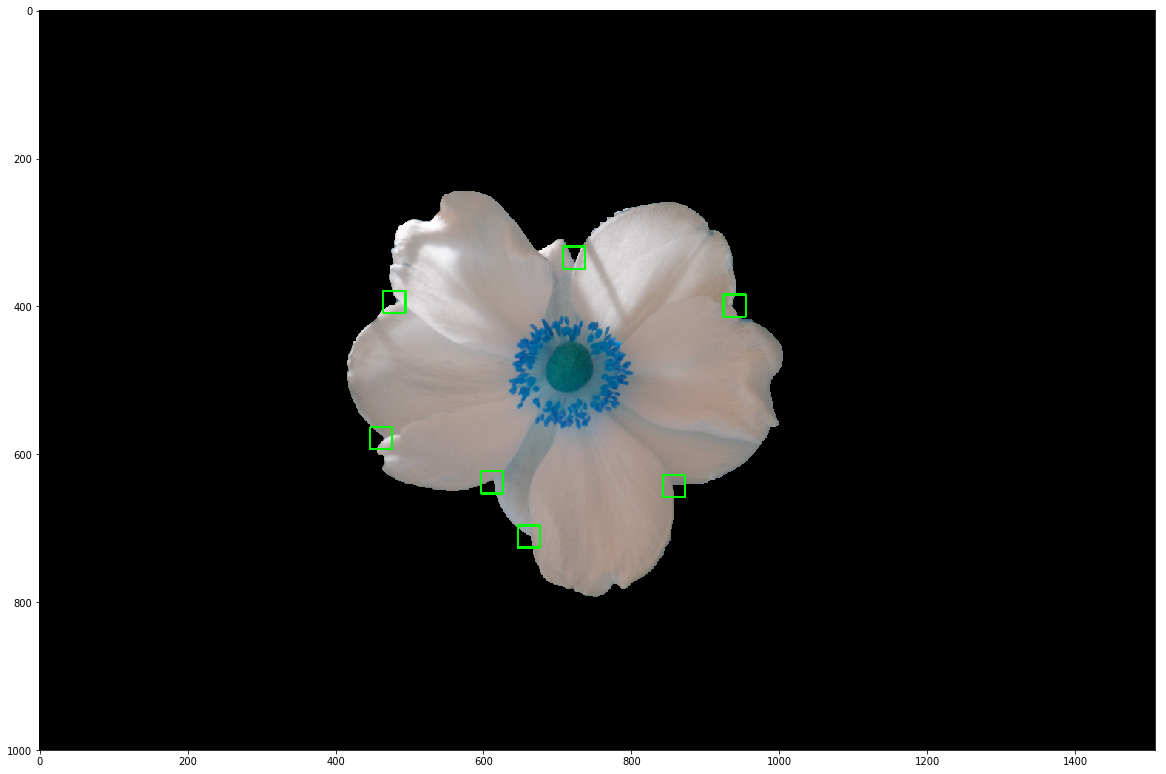

In [6]:
fname = '1.png'
corners = corner_coord(fname)[1:]
img = cv2.imread(path_fore + fname)
img_ = img + 0

l =15

for i  in range(len(corners)):
    x, y = int(corners[i][0]), int(corners[i][1])
#     cv2.circle(img_, (x, y), 1, [255,255,0],7)
    img_ = cv2.rectangle(img_, (x-l, y-l), (x+l, y+l), (0, 255, 0), thickness=2)
    pname = str(i) + '.png'
    patch = img[y-l:y+l, x-l:x+l]
#     cv2.imwrite(path_patch + pname, patch)



show(img_)
# cv2.imwrite(path_patch + fname, img_)

In [7]:
def get_radius(mask_img):
    contours,hierarchy = cv2.findContours(mask_img, 1, 2)
    for i in range(len(contours)):
        if len(contours[i]) > 0:

            # remove small objects
            if cv2.contourArea(contours[i]) < 1500:
                continue
            else:
                cnt = contours[i]
                (x,y),radius = cv2.minEnclosingCircle(cnt)
                return int(radius/5)

In [8]:
def corner_coord(fname):
    corner_img = cv2.imread(path_corner + fname)
    corner_gray = cv2.cvtColor(corner_img, cv2.COLOR_BGR2GRAY)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(corner_gray)
    return centroids[1:]

In [9]:
def find_IS_coordinate(center, radius, boundary_copy_img):
    '''
    is >> intersection
    
    input:
        center >> - of circle (x,y)
        radius >> - of circles
        boundary_copy_img >> -
    output:
        cx, cy >> coordinate of a circle center
        cx1, cy1 >> coordinate of intersection1
        cx2, cy2 >> coordinate of intersection2
    '''
    shape = boundary_copy_img.shape
    blank = np.zeros(shape, np.uint8)
    blank = cv2.circle(blank, center, radius, [255,255,0],1)
#     boundary_copy_img = cv2.circle(boundary_copy_img, center, radius, [255,255,0],1)


    # find IS
    intersection_img = cv2.bitwise_and(boundary_img, blank)
    gray_is = cv2.cvtColor(intersection_img, cv2.COLOR_BGR2GRAY)
    _, gray_is = cv2.threshold(gray_is, 1, 255, cv2.THRESH_BINARY)
    gray_is = cv2.dilate(gray_is,None)
    contours, hierarchy = cv2.findContours(gray_is, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    coord_list = []
    # intersections per acircle == 2
    if (len(contours)) < 2:
        return 0
    for k in range(2):
        M = cv2.moments(contours[k])
        if M['m00'] == 0:
            continue
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        # contour重心(交点)をlistに
        coord_list.append((cx, cy))

    cx, cy = center
    cx1, cy1 = coord_list[0] 
    cx2, cy2 = coord_list[1]
    return (cx, cy, cx1, cy1, cx2, cy2)

In [10]:
def synthesis(img1, img2):
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    _,gray_img1 = cv2.threshold(gray_img1,1,255,0)
    _,gray_img2 = cv2.threshold(gray_img2,1,255,0)
    not1 = cv2.bitwise_not(gray_img1)
    not2 = cv2.bitwise_not(gray_img2)
    
    bitwise_and1 = cv2.bitwise_and(img2, img2, mask = not1)
    bitwise_and2 = cv2.bitwise_and(img1, img1, mask = not2)

    synthetic_img_1on2 = cv2.bitwise_or(img1, bitwise_and1)
    synthetic_img_2on1 = cv2.bitwise_or(img2, bitwise_and2)
    
    return synthetic_img_1on2, synthetic_img_2on1

In [11]:
# red: foreground, green: background

def synthesis_mask(img1, img2):
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    _,gray_img1 = cv2.threshold(gray_img1,1,255,0)
    _,gray_img2 = cv2.threshold(gray_img2,1,255,0)
    not1 = cv2.bitwise_not(gray_img1)
    not2 = cv2.bitwise_not(gray_img2)
    gray1in_rbg = cv2.cvtColor(gray_img1, cv2.COLOR_GRAY2BGR)
    gray2in_rbg = cv2.cvtColor(gray_img2, cv2.COLOR_GRAY2BGR)
    
    red = np.ones(patch1.shape,np.uint8)*255
    red[:, :, (1, 2)] = 0
    green = np.ones(patch1.shape,np.uint8)*255
    green[:, :, (0, 2)] = 0


    bground2 = cv2.bitwise_and(gray2in_rbg, red, mask = not1)
    bground1 = cv2.bitwise_and(gray1in_rbg, green, mask = not2)

    fground1 = cv2.bitwise_and(green, green, mask = gray_img1)
    fground2 = cv2.bitwise_and(red, red, mask = gray_img2)

    
    mask_img_1on2 = cv2.bitwise_or(fground1, bground2)
    mask_img_2on1 = cv2.bitwise_or(fground2, bground1)
    
    return mask_img_1on2, mask_img_2on1

In [12]:
def calc_radian_and_check_lr(C):
    cx, cy, cx1, cy1, cx2, cy2 = C
    
    mx, my = (cx1+cx2)/2, (cy1+cy2)/2
    v1 = np.array([0, 1])
    v2 = np.array([mx - cx, cy - my])
#     print(v1, v2)

    cos_theta = np.inner(v1, v2) /  (np.linalg.norm(v1) * np.linalg.norm(v2))
    theta = math.acos(np.clip(cos_theta, -1.0, 1.0))

    if mx - cx > 0:
        theta *= -1
        
    d_left = (-(my-cy) - (cx1-cx))**2 + ((mx-cx) - (cy1-cy))**2
    d_right = ((my-cy) - (cx1-cx))**2 + (-(mx-cx) - (cy1-cy))**2
    if(d_left < d_right):
        lr = 'left'
    else: lr = 'right'
    
    return math.degrees(theta), lr

In [13]:
def calc_radian(C):
    cx, cy, cx1, cy1, cx2, cy2 = C
    
    mx, my = (cx1+cx2)/2, (cy1+cy2)/2
    v1 = np.array([0, 1])
    v2 = np.array([mx - cx, cy - my])
#     print(v1, v2)

    cos_theta = np.inner(v1, v2) /  (np.linalg.norm(v1) * np.linalg.norm(v2))
    theta = math.acos(np.clip(cos_theta, -1.0, 1.0))

    
    return math.degrees(theta)

In [14]:
def affine(theta, img_):
    center = (int(img_.shape[1]/2), int(img_.shape[0]/2))
    #回転角を指定
    angle = theta * (-1)
    #スケールを指定
    scale = 1.0
    #getRotationMatrix2D関数を使用
    trans = cv2.getRotationMatrix2D(center, angle , scale)
    #アフィン変換
    
    img_ = cv2.warpAffine(img_, trans, (img_.shape[1], img_.shape[0]))
    return img_

In [15]:
def wind(theta):
    if 0<= theta < 30: return 30
    elif 150 <= theta < 180: return 150
    elif -30 <= theta < 0: return -30
    elif 180 <= theta < -150: return -150
    else: return theta

In [38]:
l = 15
l2 = int(l * 0.7)


for i in range(len(fnames)):
    fname = fnames[i]
    fname = '0.png'
    print(fname, i)
    no_ = re.sub('.png', '', fname)
    
    # i >> img, m >> mask
#     if not os.path.exists('../../img/patch4/i' + no_): os.makedirs('../../img/patch4/i' + no_)
#     if not os.path.exists('../../img/patch4/m' + no_): os.makedirs('../../img/patch4/m' + no_)
        
# =====load img======    
    img = cv2.imread(path_fore + fname)
    img_copy = img + 0
    img_copy2 = img + 0
    blank1 = np.zeros(img.shape, np.uint8)
    blank2 = np.zeros(img.shape, np.uint8)
    mask_img = cv2.imread(path_mask + fname, cv2.IMREAD_GRAYSCALE)
    boundary_img = cv2.imread(path_boundary + fname)
    boundary_copy = boundary_img + 0
    boundary_copy2 = boundary_img + 0
# =====load img======    

    radius = get_radius(mask_img)
    corner = corner_coord(fname)
    
    
    for j in range(len(corner)):
        center = (int(corner[j][0]), int(corner[j][1]))
#         C = find_IS_coordinate(center, int(radius*0.3), boundary_copy) # find intersections, then record in C
        C = find_IS_coordinate(center, 18, boundary_copy) # find intersections, then record in C
        if(C == 0): 
            img_copy = cv2.circle(img_copy2, center, 1, [0,0,255],5)
            continue
        cx, cy, cx1, cy1, cx2, cy2 = C
        theta, lr = calc_radian_and_check_lr(C)
#         print(lr)
        
        
        patch1 = img[cy1-l:cy1+l, cx1-l:cx1+l]
        patch2 = img[cy2-l:cy2+l, cx2-l:cx2+l]
        
        try:
            boundary_copy2 = cv2.circle(boundary_copy2, (cx,cy), 1, [0,255,0],7)
            boundary_copy2 = cv2.circle(boundary_copy2, (cx1,cy1), 1, [0,0,255],7)
            boundary_copy2 = cv2.circle(boundary_copy2, (cx2,cy2), 1, [0,0,255],7)
            img_copy2 = cv2.rectangle(img_copy2, (cx1-l, cy1-l), (cx1+l, cy1+l), (0, 255, 0), thickness=2)
            img_copy2 = cv2.rectangle(img_copy2, (cx2-l, cy2-l), (cx2+l, cy2+l), (0, 255, 0), thickness=2)

            syn1, syn2 = synthesis(patch1, patch2)
            mask1, mask2 = synthesis_mask(patch1, patch2)
            
            syn1_ = affine(theta, syn1)
            syn2_ = affine(theta, syn2)
            mask1_ = affine(theta, mask1)
            mask2_ = affine(theta, mask2)
            syn1__ = syn1_[l-l2:l+l2, l-l2:l+l2]
            syn2__ = syn2_[l-l2:l+l2, l-l2:l+l2]
            mask1__ = mask1_[l-l2:l+l2, l-l2:l+l2]
            mask2__ = mask2_[l-l2:l+l2, l-l2:l+l2]
            break

#             if(lr == 'right'):
#                 syn1__ = cv2.flip(syn1__, 1)
#                 syn2__ = cv2.flip(syn2__, 1)
#                 mask1__ = cv2.flip(mask1__, 1)
#                 mask2__ = cv2.flip(mask2__, 1)
#             plt.imshow(mask1__), plt.show()
#             plt.imshow(cv2.flip(mask2__, 1)), plt.show()
#             cv2.imwrite('../../img/patch4/img/' + no_ + '_'  + str(2*j) + '.png', cv2.flip(syn1__, 1))
#             cv2.imwrite('../../img/patch4/mask_check/' + no_ + '_'  + str(2*j) + '.png', cv2.flip(mask1__, 1))
#             cv2.imwrite('../../img/patch4/mask_check/' + no_ + '_'  + str(2*j+1) + '.png', cv2.flip(mask2__, 1))
#             cv2.imwrite('../../img/patch4/img/' + no_ + '_'  + str(2*j) + '.png', syn1__)
#             cv2.imwrite('../../img/patch4/mask/' + no_ + '_'  + str(2*j) + '.png', mask1__)
#             cv2.imwrite('../../img/patch4/img/' + no_ + '_'  + str(2*j+1) + '.png', syn2__)
#             cv2.imwrite('../../img/patch4/mask/' + no_ + '_'  + str(2*j+1) + '.png', mask2__)
            
        except:
                import traceback
                traceback.print_exc()
                print(fname, '('+str(2*j)+')')
                continue

#     cv2.imwrite('../../img/patch4/whole_img/' + fname, img_copy2)
#     cv2.imwrite('../../img/patch4/dot/' + fname, boundary_copy2)

#     show(boundary_copy2)
    

#     if i > 10: break
    break


0.png 0


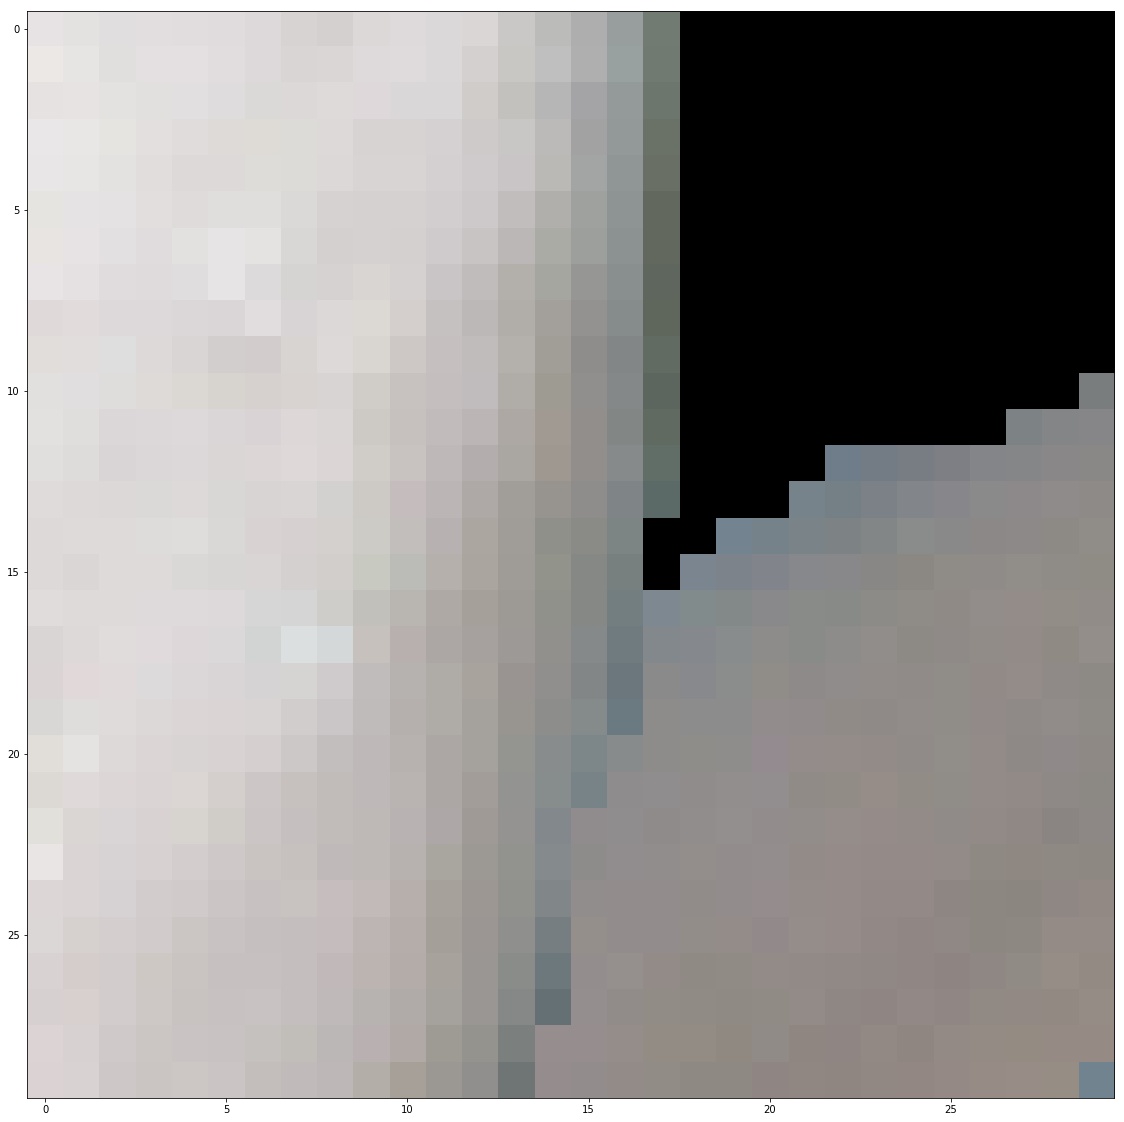

In [40]:
img = cv2.imread('../../img/foreground2_fixed/0.png')
show(syn2)

In [56]:
# 確認用
l = 15
l2 = int(l * 0.7)


for i in range(len(fnames)):
    cnt = 0
    fname = fnames[i]
#     fname = '41.png'
    print(fname, i)
    no_ = re.sub('.png', '', fname)
    
    # i >> img, m >> mask
#     if not os.path.exists('../../img/patch3/i' + no_): os.makedirs('../../img/patch3/i' + no_)
#     if not os.path.exists('../../img/patch3/m' + no_): os.makedirs('../../img/patch3/m' + no_)
        
# =====load img======    
    img = cv2.imread(path_fore + fname)
    img_copy = img + 0
    img_copy2 = img + 0
    blank1 = np.zeros(img.shape, np.uint8)
    blank2 = np.zeros(img.shape, np.uint8)
    mask_img = cv2.imread(path_mask + fname, cv2.IMREAD_GRAYSCALE)
    boundary_img = cv2.imread(path_boundary + fname)
    boundary_copy = boundary_img + 0
    boundary_copy2 = boundary_img + 0
# =====load img======    

    radius = get_radius(mask_img)
    corner = corner_coord(fname)
#     print(corner)
    
    
    for j in range(len(corner)):
        center = (int(corner[j][0]), int(corner[j][1]))
#         C = find_IS_coordinate(center, int(radius*0.3), boundary_copy) # find intersections, then record in C
        C = find_IS_coordinate(center, 18, boundary_copy) # find intersections, then record in C
    
        boundary_copy2 = cv2.circle(boundary_copy2, (int(corner[j][0]), int(corner[j][1])), 1, [0,255,0],7)
        boundary_copy2 = cv2.circle(boundary_copy2, (int(corner[j][0]), int(corner[j][1])), 18, [0,0,255],2)
        boundary_copy2 = cv2.circle(boundary_copy2, (int(corner[j][0]), int(corner[j][1])), 18, [0,0,255],2)
        if(C == 0): 
            img_copy = cv2.circle(img_copy2, center, 1, [0,0,255],5)
            continue
        cx, cy, cx1, cy1, cx2, cy2 = C
        theta = calc_radian(C)
        
        
        patch1 = img[cy1-l:cy1+l, cx1-l:cx1+l]
        patch2 = img[cy2-l:cy2+l, cx2-l:cx2+l]
        cnt += 1
        
        try:

            img_copy2 = cv2.rectangle(img_copy2, (cx1-l, cy1-l), (cx1+l, cy1+l), (0, 255, 0), thickness=2)
            img_copy2 = cv2.rectangle(img_copy2, (cx2-l, cy2-l), (cx2+l, cy2+l), (0, 255, 0), thickness=2)

            syn1, syn2 = synthesis(patch1, patch2)
            mask1, mask2 = synthesis_mask(patch1, patch2)
            
            syn1_ = affine(theta, syn1)
            syn2_ = affine(theta, syn2)
            mask1_ = affine(theta, mask1)
            mask2_ = affine(theta, mask2)
            syn1__ = syn1_[l-l2:l+l2, l-l2:l+l2]
            syn2__ = syn2_[l-l2:l+l2, l-l2:l+l2]
            mask1__ = mask1_[l-l2:l+l2, l-l2:l+l2]
            mask2__ = mask2_[l-l2:l+l2, l-l2:l+l2]
#             cv2.imwrite('../../img/patch3/img/' + no_ + '_'  + str(2*j) + '.png', syn1__)
#             cv2.imwrite('../../img/patch3/mask/' + no_ + '_'  + str(2*j) + '.png', mask1__)
#             cv2.imwrite('../../img/patch3/img/' + no_ + '_'  + str(2*j+1) + '.png', syn2__)
#             cv2.imwrite('../../img/patch3/mask/' + no_ + '_'+ str(2*j+1) + '.png', mask2__)
            
        except:
                import traceback
                traceback.print_exc()
                print(fname, '('+str(2*j)+')')
                continue

    cv2.imwrite('../../img/patch3/whole_img/' + fname, img_copy2)
    cv2.imwrite('../../img/patch3/dot/' + fname, boundary_copy2)
    print(cnt)

#     show(boundary_copy2)
    

#     if i > 10: break
#     break


0.png 0


NameError: name 'calc_radian' is not defined

### 自然画像の花びら境界切り抜き

In [27]:
l = 15
l2 = int(l * 0.7)


for i in range(len(fnames)):
    fname = fnames[i]
#     fname = '16.png'
    print(fname, i)
    no_ = re.sub('.png', '', fname)
    
    # i >> img, m >> mask
#     if not os.path.exists('../../img/patch4/i' + no_): os.makedirs('../../img/patch4/i' + no_)
#     if not os.path.exists('../../img/patch4/m' + no_): os.makedirs('../../img/patch4/m' + no_)
        
# =====load img======    
    img = cv2.imread(path_fore + fname)
    img_copy = img + 0
    img_copy2 = img + 0
    blank1 = np.zeros(img.shape, np.uint8)
    blank2 = np.zeros(img.shape, np.uint8)
    mask_img = cv2.imread(path_mask + fname, cv2.IMREAD_GRAYSCALE)
    boundary_img = cv2.imread(path_boundary + fname)
    boundary_copy = boundary_img + 0
    boundary_copy2 = boundary_img + 0
# =====load img======    

#     radius = get_radius(mask_img)
    corner = corner_coord(fname)
    
    
    for j in range(len(corner)):
        center = (int(corner[j][0]), int(corner[j][1]))
#         C = find_IS_coordinate(center, int(radius*0.3), boundary_copy) # find intersections, then record in C
        C = find_IS_coordinate(center, 18, boundary_copy) # find intersections, then record in C
        if(C == 0): 
            img_copy = cv2.circle(img_copy2, center, 1, [0,0,255],5)
            continue
        cx, cy, cx1, cy1, cx2, cy2 = C
        theta, lr = calc_radian_and_check_lr(C)
#         print(lr)
        
        
        patch = img[cy-l:cy+l, cx-l:cx+l]
        
        try:
            img_copy2 = cv2.rectangle(img_copy2, (cx-l, cy-l), (cx+l, cy+l), (0, 255, 0), thickness=2)

            patch_ = affine(theta, patch)
            patch__ = patch_[l-l2+3:l+l2+3, l-l2:l+l2]



            cv2.imwrite('../../img/patch4/natural/' + no_ + '_'  + str(j) + '.png', patch__)
        except:
                import traceback
                traceback.print_exc()
                print(fname, '('+str(2*j)+')')
                continue

#     cv2.imwrite('../../img/patch4/whole_img/' + fname, img_copy2)
#     if i > 10: break
#     break


0.png 0
1.png 1
100.png 2
101.png 3
102.png 4
103.png 5
104.png 6
105.png 7
106.png 8
107.png 9
108.png 10
109.png 11
11.png 12
110.png 13
111.png 14
112.png 15
113.png 16
114.png 17
115.png 18
116.png 19
117.png 20
118.png 21
119.png 22
12.png 23


/Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/synthe/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


120.png 24
121.png 25
122.png 26
123.png 27
124.png 28
125.png 29
126.png 30
127.png 31
128.png 32
129.png 33
130.png 34
131.png 35
132.png 36
133.png 37
134.png 38
135.png 39
136.png 40
137.png 41
138.png 42
139.png 43
140.png 44
141.png 45
142.png 46
143.png 47
144.png 48
145.png 49
146.png 50
147.png 51
148-1.png 52
149.png 53
150.png 54
151.png 55
152.png 56
153.png 57
154.png 58
155.png 59
156.png 60
157.png 61
158.png 62
159.png 63
16.png 64
160.png 65
161.png 66
163-2.png 67
163.png 68
164.png 69
165.png 70
167.png 71
168.png 72
169.png 73
17.png 74
170.png 75
172.png 76
178.png 77
18.png 78
180.png 79
181.png 80
182.png 81
183.png 82
184.png 83
185.png 84
186.png 85
187.png 86
188.png 87
189.png 88
19.png 89
190.png 90
191.png 91
192.png 92
193.png 93
194.png 94
195-2.png 95
195.png 96
196.png 97
197.png 98
198.png 99
199.png 100
2.png 101
20.png 102
200.png 103
202.png 104
204.png 105
205.png 106
206.png 107
207.png 108
208.png 109
209.png 110
21.png 111
210.png 112
212.png 11

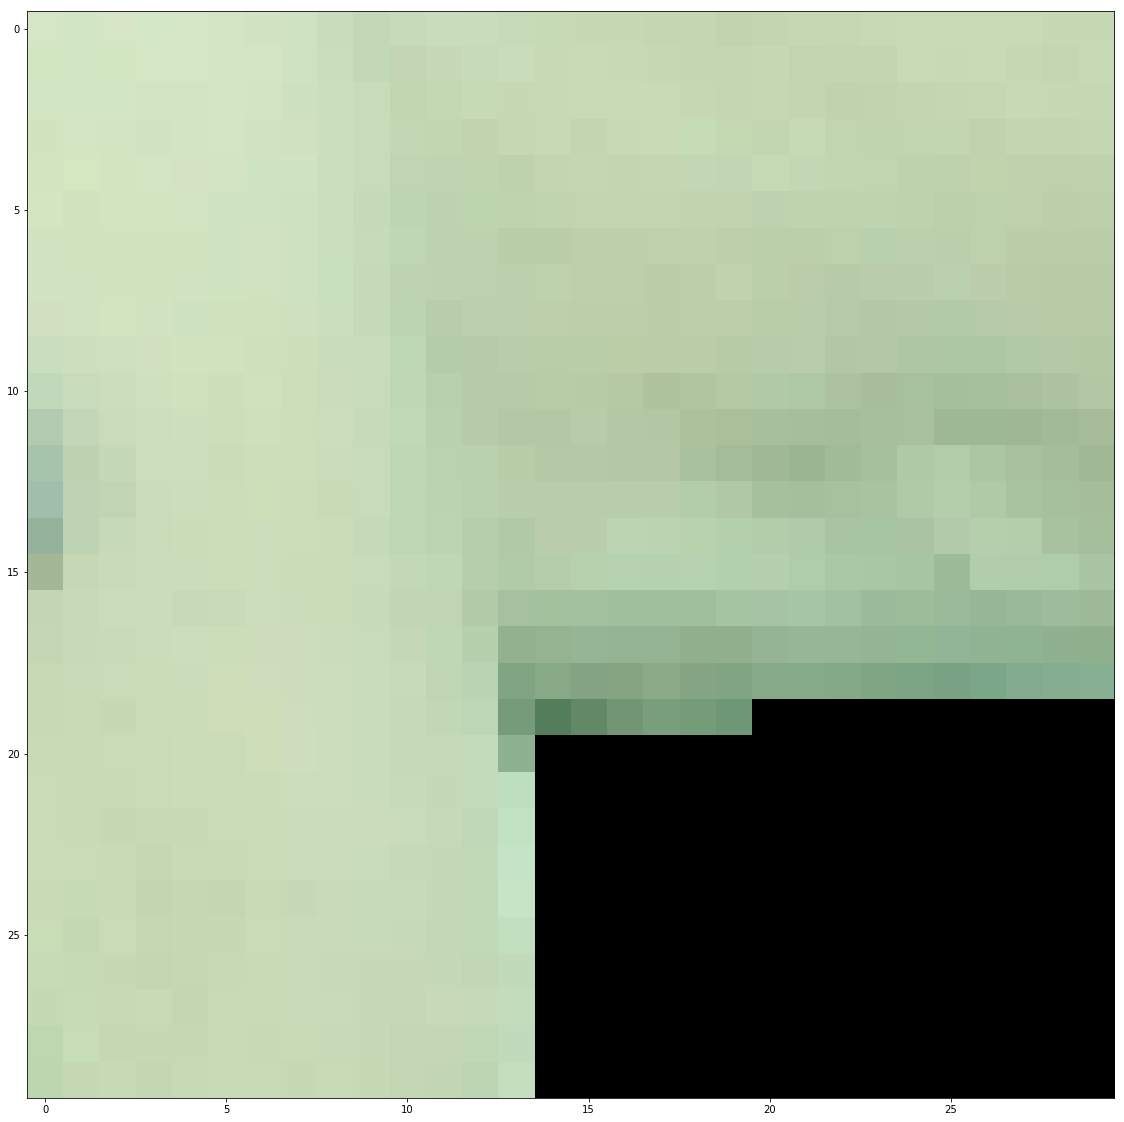

In [25]:
show(patch)